# Quasi-Univeral Relation Fits and Plots

We used fits of the following form:

$log_{10}(Mf) = a + b (\Lambda)^{1/5}$

for the subset of equal mass binaries and

$log_{10}(Mf) = a_0 + (b_0 + b_1 q + b_2 q^2)(\Lambda)^{1/5}$ 

for all systems (including unequal mass binaries) for all the quasi-universal frequency relations studied.

The term in the logarithm, $Mf$ is changed to $t/M$ for the quasi-universal relation for time

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
import statsmodels.api as sm

In [6]:
#Import the data
#df = pd.read_csv('./Summary_Data/V4_All_Codes_Summary.txt', sep='\t')
df = pd.read_csv('./Summary_Data/V6_All_Codes_Summary.txt', sep='\t')
print(df)

         Run Name   Code    Identifier   M_chirp            Λ  \
0    125H_073_253  SACRA  125H_107_146  1.085470  1335.000000   
1    125H_080_252  SACRA  125H_112_140  1.088748  1332.000000   
2    125H_073_274  SACRA  125H_116_158  1.175761   848.000000   
3    125H_075_273  SACRA  125H_117_156  1.173691   837.000000   
4    125H_076_273  SACRA  125H_118_155  1.175156   855.000000   
..            ...    ...           ...       ...          ...   
270   SLy_066_270    BAM       BAM0136  1.146868   455.390560   
271   SLy_079_270    BAM       BAM0137  1.166597   411.185920   
272  MPA1_090_331    BAM       BAM0138  1.440002   178.928784   
273  MPA1_080_333    BAM       BAM0139  1.440003   178.613633   
274  MPA1_100_331    BAM       BAM0140  1.440996   178.208925   

                 fmrg,h           fmrg,psi4              fmax,h  \
0    1.3214362146321363   1.733428397624307  2.5587695285670846   
1     1.408507095182782   1.936566093556757   9.369056671888158   
2    1.39279980992

Determine the EOS mass ratio and total mass from the Run Name parameter.

In [7]:
parameters = [[],[],[]]
for name in df['Run Name']:
    print(name)
    terms = name.split('_')
    #print(terms)
    parameters[0].append(terms[0])
    parameters[1].append(float(terms[1])/100)
    
    divis = 10**(len(terms[2])-1)  #This is to compensate for the one that only has 2 digits for the mass
    print(len(terms[2]), float(terms[2])/divis)
    parameters[2].append(float(terms[2])/divis)
    
    if float(terms[2])/divis > 10 or float(terms[2])/divis < 0.5:
        print('ERROR')
    
print(parameters)
    

125H_073_253
3 2.53
125H_080_252
3 2.52
125H_073_274
3 2.74
125H_075_273
3 2.73
125H_076_273
3 2.73
125H_080_272
3 2.72
125H_100_250
3 2.5
125H_086_271
3 2.71
125H_100_270
3 2.7
15H_073_253
3 2.53
15H_080_252
3 2.52
15H_073_274
3 2.74
15H_075_273
3 2.73
15H_076_273
3 2.73
15H_080_272
3 2.72
15H_100_250
3 2.5
15H_086_271
3 2.71
15H_100_270
3 2.7
B_073_253
3 2.53
B_080_252
3 2.52
B_073_274
3 2.74
B_075_273
3 2.73
B_076_273
3 2.73
B_080_272
3 2.72
B_100_250
3 2.5
B_086_271
3 2.71
B_100_270
3 2.7
H_073_253
3 2.53
H_080_252
3 2.52
H_073_274
3 2.74
H_075_273
3 2.73
H_076_273
3 2.73
H_080_272
3 2.72
H_100_250
3 2.5
H_086_271
3 2.71
H_100_270
3 2.7
HB_073_253
3 2.53
HB_080_252
3 2.52
HB_073_274
3 2.74
HB_075_273
3 2.73
HB_076_273
3 2.73
HB_080_272
3 2.72
HB_100_250
3 2.5
HB_086_271
3 2.71
HB_100_270
3 2.7
SFHo_100_270
3 2.7
hMlR_100_272
3 2.72
hMlR_090_272
3 2.72
hMlR_083_273
3 2.73
lMhR_100_272
3 2.72
lMhR_090_272
3 2.72
lMhR_083_273
3 2.73
ALF2_100_240
3 2.4
ALF2_100_245
3 2.45
ALF2_100_250


In [8]:
#Define the Quantity we want to fit (This is the the quantity for Psi4, as it need some scaling fixed)
fit_q = 'fmrg,psi4'

### Identifying the outliers (For removal Below)

SACRA
SXS
Whisky
THC
BAM
102
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     33.29
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           8.92e-08
Time:                        09:11:19   Log-Likelihood:                 43.068
No. Observations:                 102   AIC:                            -82.14
Df Residuals:                     100   BIC:                            -76.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5981  

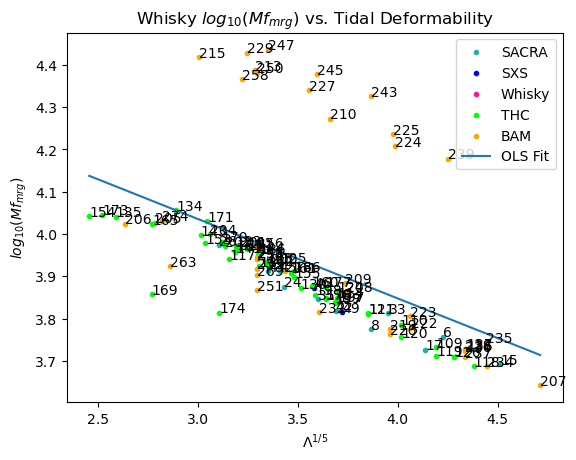

In [10]:
#Code_List = ['SACRA', 'SXS', 'Whisky', 'THC', 'BAM'] 
Code_List = ['SACRA', 'SXS', 'Whisky', 'THC', 'BAM'] 
#EOS_List = ['ALF2', 'APR4', 'GNH3', 'H4', 'SLy'] #Without GAM2 for comparison to paper

#Define color dictionary
color_dict = {
    'SACRA': 'lightseagreen',
    'SXS': 'b',
    'Whisky': 'deeppink',
    'THC': 'lime',
    'BAM': 'orange',
}

fig, ax = plt.subplots()

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            plt.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], marker='.', label=df['Code'][i-1])
            print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            if 1 - parameters[1][i] <= 0.01: #0.01 seems to include only q=1
                #print(parameters[1][i])
            
                #This was to check the types to ensure we could multiply
                #print(type((parameters[2][i])), type(df['f2,h [R01]'][i]), type(df['Λ'][i]))

                Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q][i])))
                Mf_List_Lambs.append(df['Λ'][i]**(1/5))
            
            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
plt.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], marker='.', label=df['Code'][name_ind])

print(len(Mf_List)) #Probably not needed as it is given in the summary
        
###-----------------------------------------------Fit------------------------------------------------------------------###

params_df = pd.DataFrame({
    'Lambda 0.2': np.array(Mf_List_Lambs)
})

params = params_df[['Lambda 0.2']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#plot our fit
test_lamb = np.linspace(min(Mf_List_Lambs),max(Mf_List_Lambs), 100)
val_fit = coefs[0] + coefs[1] * test_lamb
plt.plot(test_lamb, val_fit, label='OLS Fit')


#plt.plot([3,3], [3.75,4], linestyle='dashed') #Highlight outlier

####-----------------------------------Plot index of each point----------------------------------###

for i in range(len(df['Code'])):
    if 1 - parameters[1][i] <= 0.01:
        if df[fit_q][i] != '-':
            plt.text(df['Λ'][i]**(1/5), np.log10(1000*(parameters[2][i])*float(df[fit_q][i])), i)

###-----------------------------------------Plot Labels--------------------------------------------###
plt.ylabel('$log_{10}(Mf_{mrg})$')
plt.xlabel('$\Lambda^{1/5}$')
plt.title('Whisky $log_{10}(Mf_{mrg})$ vs. Tidal Deformability')
plt.legend()
plt.show()

        

### Identifying Mass Scaled Runs

SACRA
SXS
Whisky
THC
BAM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     37.98
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           3.65e-09
Time:                        09:11:30   Log-Likelihood:                 72.929
No. Observations:                 210   AIC:                            -141.9
Df Residuals:                     208   BIC:                            -135.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4030      

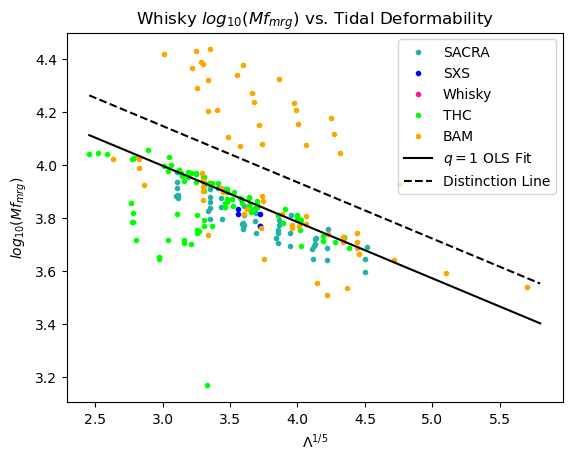

In [11]:
#Code_List = ['SACRA', 'SXS', 'Whisky', 'THC', 'BAM'] 
Code_List = ['SACRA', 'SXS', 'Whisky', 'THC', 'BAM'] 
#EOS_List = ['ALF2', 'APR4', 'GNH3', 'H4', 'SLy'] #Without GAM2 for comparison to paper

#Define color dictionary
color_dict = {
    'SACRA': 'lightseagreen',
    'SXS': 'b',
    'Whisky': 'deeppink',
    'THC': 'lime',
    'BAM': 'orange',
}

fig, ax = plt.subplots()

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            plt.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], marker='.', label=df['Code'][i-1])
            print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            #This was to check the types to ensure we could multiply
            #print(type((parameters[2][i])), type(df['f2,h [R01]'][i]), type(df['Λ'][i]))
            
            Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q][i])))
            Mf_List_Lambs.append(df['Λ'][i]**(1/5))
            
            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
plt.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], marker='.', label=df['Code'][name_ind])
        
###-----------------------------------------------Fit------------------------------------------------------------------###

params_df = pd.DataFrame({
    'Lambda 0.2': np.array(Mf_List_Lambs)
})

params = params_df[['Lambda 0.2']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#plot our fit
#test_lamb = np.linspace(min(Mf_List_Lambs),max(Mf_List_Lambs), 100)
#val_fit = coefs[0] + coefs[1] * test_lamb
#plt.plot(test_lamb, val_fit, label='OLS Fit')


test_lamb = np.linspace(min(Mf_List_Lambs),5.8, 100)
val_fit = 4.6339 - 0.2122 * test_lamb
plt.plot(test_lamb, val_fit, color='k', label=r'$q=1$ OLS Fit')

#test_lamb = np.linspace(min(Mf_List_Lambs),max(Mf_List_Lambs), 100)
val_fit = 0.15 + 4.6339 - 0.2122 * test_lamb
plt.plot(test_lamb, val_fit, color='k', linestyle='dashed', label=r'Distinction Line')

##plot reference
#val_test = 4.242 - 0.154544 * np.array(Mf_List_Lambs)
#plt.plot(Mf_List_Lambs, val_test, linestyle='dotted', label='Rezolla and Takami, 2016')

###----------------------------Identify the Indices of BAM Runs that need rescaled by 1/mass----------------------------###
rescale_runs = []
div1 = 0.15 + 4.6339 - 0.2122 * (np.array(df['Λ'])**(1/5))
for i in range(len(df['Code'])):
    if df[fit_q][i] != '-':
        if df['Code'][i] == 'BAM' and float(df[fit_q][i]) >= div1[i]:
            rescale_runs.append(i)
        
print(rescale_runs)
print(len(rescale_runs))


plt.ylabel('$log_{10}(Mf_{mrg})$')
plt.xlabel('$\Lambda^{1/5}$')
plt.title('Whisky $log_{10}(Mf_{mrg})$ vs. Tidal Deformability')
plt.legend()
plt.show()


### Without Rescaling BAM Data

SACRA
SXS
Whisky
THC
BAM
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     33.29
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           8.92e-08
Time:                        09:14:05   Log-Likelihood:                 43.068
No. Observations:                 102   AIC:                            -82.14
Df Residuals:                     100   BIC:                            -76.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5981      

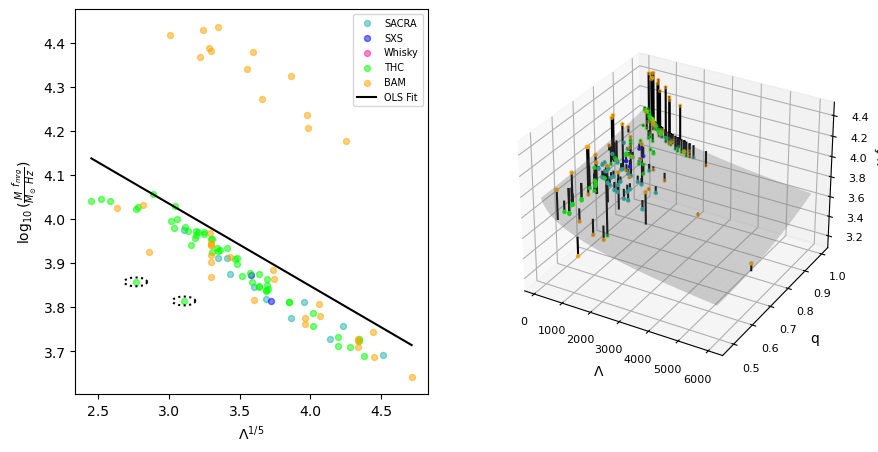

In [13]:
#fig,ax = plt.subplot(2,1,figsize=(10,5))
Code_List = ['SACRA', 'SXS', 'Whisky', 'THC', 'BAM'] 
#Code_List = ['SACRA', 'Whisky', 'THC', 'BAM'] 
#Code_List = ['SACRA', 'SXS', 'Whisky','BAM']
#EOS_List = ['ALF2', 'APR4', 'GNH3', 'H4', 'SLy'] #Without GAM2 for comparison to paper
Outliers = [169,174]

#Define color dictionary
color_dict = {
    'SACRA': 'lightseagreen',
    'SXS': 'b',
    'Whisky': 'deeppink',
    'THC': 'lime',
    'BAM': 'orange',
}



fig = plt.figure(figsize=(10, 5))
###---------------------------------Equal Mass Binaries (q=1) ---------------------------------------------------###
#Create Subplot
ax1 = fig.add_subplot(1,2,1)

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            plt.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], alpha=0.5, s=75, marker='.', label=df['Code'][i-1])
            print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            if 1 - parameters[1][i] <= 0.01: #0.01 seems to include only q=1
                #print(parameters[1][i])
            

                Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q][i])))
                Mf_List_Lambs.append(df['Λ'][i]**(1/5))
            
            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
ax1.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], alpha=0.5, s=75, marker='.', label=df['Code'][name_ind])

        
###-----------------------------------------------Fit------------------------------------------------------------------###

params_df = pd.DataFrame({
    'Lambda 0.2': np.array(Mf_List_Lambs)
})

params = params_df[['Lambda 0.2']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#plot our fit
test_lamb = np.linspace(min(Mf_List_Lambs),max(Mf_List_Lambs), 100)
val_fit = coefs[0] + coefs[1] * test_lamb
plt.plot(test_lamb, val_fit, color='k', label='OLS Fit')



###------------------------------------------Circle Outliers------------------------------------------------###
for ind in Outliers:
    theta = np.linspace(0,2*np.pi,100)
    x1 = 8*(0.01)*np.cos(theta)
    y1 = 0.01*np.sin(theta)
    ax1.plot(x1+df['Λ'][ind]**(1/5),y1+np.log10(1000*(parameters[2][ind])*float(df[fit_q][ind])), color='k', linestyle='dotted')
    #ax1.Circle((df['Λ'][ind]**(1/5), np.log10(1000*(parameters[2][ind])*float(df['fmrg,h'][ind]))), 2, fill=False)

###---------------------------------------Plot Labels-------------------------------------------------------###
#ax1.set_ylabel('$log_{10}(Mf_{mrg})$')
ax1.set_ylabel(r'$\log_{10}(\frac{M}{M_{\odot}} \frac{f_{mrg}}{Hz})$')
ax1.set_xlabel('$\Lambda^{1/5}$')
#plt.title('Whisky $log_{10}(Mf_{mrg})$ vs. Tidal Deformability')
ax1.legend(prop={'size':7})
#plt.show()


        


###---------------------------------Unequal Mass Binaries Included-----------------------------------------------###

ax = fig.add_subplot(1,2,2,projection = '3d')

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []
Mf_List_qs = []
Mf_List_qLambs = []
Mf_List_q2Lambs = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            if df['Code'][i-1] in Code_List:
                ax.scatter(np.array(Mf_List_Lambs[start_ind:])**5, Mf_List_qs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], marker='.', label=df['Code'][i-1])
                print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            #This was to check the types to ensure we could multiply
            #print(type((parameters[2][i])), type(df['f2,h [R01]'][i]), type(df['Λ'][i]))
            
            Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q][i])))
            Mf_List_Lambs.append(df['Λ'][i]**(1/5))
            Mf_List_qs.append(parameters[1][i])
            Mf_List_qLambs.append(parameters[1][i]*(df['Λ'][i]**(1/5)))
            Mf_List_q2Lambs.append((parameters[1][i]**2)*(df['Λ'][i]**(1/5)))
            
            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
ax.scatter(np.array(Mf_List_Lambs[start_ind:])**5, Mf_List_qs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], marker='.', label=df['Code'][name_ind])
        
###-----------------------------------------------Fit------------------------------------------------------------------###

print(len(Mf_List_Lambs))
print(len(Mf_List_qs))
print(len(Mf_List_qLambs))
print(len(Mf_List_q2Lambs))
params_df = pd.DataFrame({
    'Lambda 0.2 (Lamb)': Mf_List_Lambs,
    'q Lamb': Mf_List_qLambs,
    'q2 Lamb': Mf_List_q2Lambs,
    'q': Mf_List_qs
})

params = params_df[['Lambda 0.2 (Lamb)', 'q Lamb', 'q2 Lamb']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#Now we want to plot the fit

#Start by making a 2D grid (meshgrid) for lambda^1/5 and q (mass ratio)
lambs_grid, qs_grid = np.meshgrid(
    np.linspace(params['Lambda 0.2 (Lamb)'].min(), params['Lambda 0.2 (Lamb)'].max(), 50),
    np.linspace(params_df['q'].min(), params_df['q'].max(), 50)
)
#print(lambs_grid)

#Prediction
mrg_freq_predict = np.array([[coefs['const']+(coefs['Lambda 0.2 (Lamb)']+coefs['q Lamb']*qs_grid[i][j]+coefs['q2 Lamb']*(qs_grid[i][j]**2))*lambs_grid[i][j] for j in range(50)] for i in range(50)])
print(mrg_freq_predict)
#mrg_freq_paper = np.array([[4.201+(-0.330+0.198*qs_grid[i][j]-0.067*(qs_grid[i][j]**2))*((3/16)**(1/5))*lambs_grid[i][j] for j in range(50)] for i in range(50)])

#for i in range
print()

#Plot Prediction
ax.plot_surface(lambs_grid**5, qs_grid, mrg_freq_predict, color='grey', alpha=0.3, label='Predicted Surface') #Color options: red,grey
#ax.plot_surface(lambs_grid, qs_grid, mrg_freq_paper, color='blue', alpha=0.3, label='Paper Predicted Surface')


###------------------------------------Adding visuals for error---------------------------------------###
#print('list coeffs')
for k in range(len(Mf_List)):
    #print(coefs[0], coefs[1], coefs[2], coefs[3])
    prediction = coefs[0] + coefs[1]*Mf_List_Lambs[k] + coefs[2]*Mf_List_qLambs[k]+ coefs[3]*Mf_List_q2Lambs[k]
    ax.plot([Mf_List_Lambs[k]**5, Mf_List_Lambs[k]**5], [Mf_List_qs[k], Mf_List_qs[k]], [prediction, Mf_List[k]], color='k')
    


###------------------------------------Plot Set-up and Labels------------------------------------------###
# Configure the plot
ax.set_xlabel('$Λ$')
ax.set_ylabel('q')
#ax.set_zlabel('$log_{10}(Mf_{mrg})$')
ax.set_zlabel(r'$\log_{10}(\frac{M}{M_{\odot}} \frac{f_{mrg}}{Hz})$')

#plt.title('$f_{mrg}$ vs. Tidal Deformability and Mass Ratio')
#ax.legend(loc='upper left', bbox_to_anchor=(1,1)) # Adjust legend location as needed
#ax.legend()
ax.grid(True)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=8)
elev = -25.0 # -30.0  #About q axis
azim = 0.0 #about frequency axis (Check (0,90,0), (0,0,0), (0,45,0), (-15,0,0) with all True) (-30,0,0) without SXS
roll = 0.0 #About lambda axis
#ax.view_init(elev, azim, roll)

#plt.show()
#fig.savefig('./Pictures/Paper_Plots/Merger_Freq_QU_Strain.png')

### Rescaled Fit Without Outliers for the Equal Mass Case

SACRA
SXS
Whisky
THC
BAM
100
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1378.
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           1.59e-59
Time:                        09:14:29   Log-Likelihood:                 225.20
No. Observations:                 100   AIC:                            -446.4
Df Residuals:                      98   BIC:                            -441.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5748  

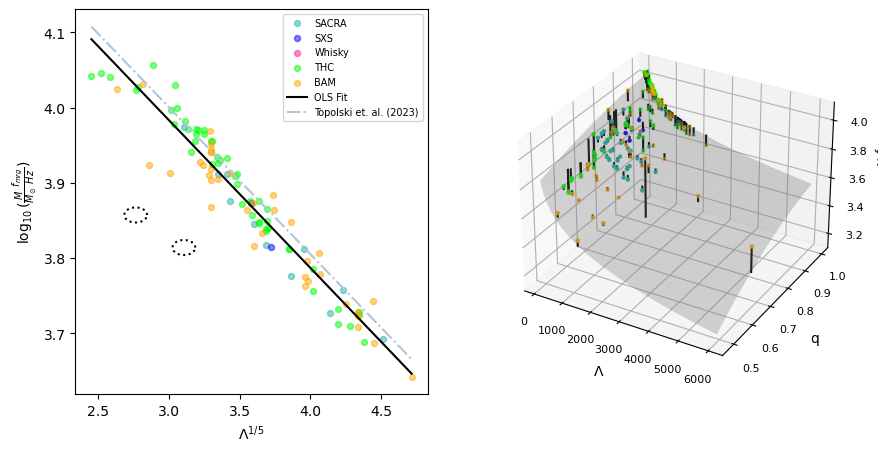

In [14]:
#Make sure to run the the code a couple cells above that finds the ones that need rescaled (defined rescale_runs list) 

#fig,ax = plt.subplot(2,1,figsize=(10,5))
Code_List = ['SACRA', 'SXS', 'Whisky', 'THC', 'BAM'] 
#Code_List = ['SACRA', 'Whisky', 'THC', 'BAM'] 
#Code_List = ['SACRA', 'SXS', 'Whisky','BAM']
#EOS_List = ['ALF2', 'APR4', 'GNH3', 'H4', 'SLy'] #Without GAM2 for comparison to paper
Outliers = [169,174]

#Define color dictionary
color_dict = {
    'SACRA': 'lightseagreen',
    'SXS': 'b',
    'Whisky': 'deeppink',
    'THC': 'lime',
    'BAM': 'orange',
}

#color_dict = {
#    'SACRA': 'teal',
#    'SXS': 'darkblue',
#    'Whisky': 'red',
#    'THC': 'purple',
#    'BAM': 'gold',
#}

fig = plt.figure(figsize=(10, 5))
###---------------------------------Equal Mass Binaries (q=1) ---------------------------------------------------###
#Create Subplot
ax1 = fig.add_subplot(1,2,1)

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            plt.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], alpha=0.5, s=75, marker='.', label=df['Code'][i-1])
            print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            if 1 - parameters[1][i] <= 0.01: #0.01 seems to include only q=1
                #print(parameters[1][i])
            
                #This was to check the types to ensure we could multiply
                #print(type((parameters[2][i])), type(df['f2,h [R01]'][i]), type(df['Λ'][i]))
                if i not in Outliers:
                    if i in rescale_runs:

                        Mf_List.append(np.log10(1000*float(df[fit_q][i]))) #Removed multiplication by M as it is already.
                        Mf_List_Lambs.append(df['Λ'][i]**(1/5))


                    else:

                        Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q][i])))
                        Mf_List_Lambs.append(df['Λ'][i]**(1/5))

            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
ax1.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], alpha=0.5, s=75, marker='.', label=df['Code'][name_ind])

print(len(Mf_List)) #Probably not needed as it is given in the summary
        
###-----------------------------------------------Fit------------------------------------------------------------------###

params_df = pd.DataFrame({
    'Lambda 0.2': np.array(Mf_List_Lambs)
})

params = params_df[['Lambda 0.2']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#plot our fit
test_lamb = np.linspace(min(Mf_List_Lambs),max(Mf_List_Lambs), 100)
val_fit = coefs[0] + coefs[1] * test_lamb
plt.plot(test_lamb, val_fit, color='k', label='OLS Fit')

#With outliers removed
#val_test = 4.2128 - 0.1473 * test_lamb
#plt.plot(test_lamb, val_test, color='k', linestyle='dotted', label='OLS Without Outliers')

#plot reference
#val_test = 4.242 - 0.154544 * test_lamb
#plt.plot(test_lamb, val_test, color='slategrey', linestyle='dotted', label='Rezolla & Takami (2016)')

#2nd reference plot
val_test = 4.589 - 0.196 * test_lamb
plt.plot(test_lamb, val_test, color='lightsteelblue', linestyle='dashdot', label='Topolski et. al. (2023)')

#3rd reference plot
#val_test = 4.2285 - 0.149 * test_lamb
#plt.plot(test_lamb, val_test, color='grey', linestyle='dashed', label='SACRA-MPI')

#plt.plot([3,3], [3.75,4], linestyle='dashed') #Highlight outlier

###------------------------------------------Circle Outliers------------------------------------------------###
for ind in Outliers:
    theta = np.linspace(0,2*np.pi,100)
    x1 = 8*(0.01)*np.cos(theta)
    y1 = 0.01*np.sin(theta)
    ax1.plot(x1+df['Λ'][ind]**(1/5),y1+np.log10(1000*(parameters[2][ind])*float(df[fit_q][ind])), color='k', linestyle='dotted')
    #ax1.Circle((df['Λ'][ind]**(1/5), np.log10(1000*(parameters[2][ind])*float(df['fmrg,h'][ind]))), 2, fill=False)

###---------------------------------------Plot Labels-------------------------------------------------------###
#ax1.set_ylabel('$log_{10}(Mf_{mrg})$')
ax1.set_ylabel(r'$\log_{10}(\frac{M}{M_{\odot}} \frac{f_{mrg}}{Hz})$')
ax1.set_xlabel('$\Lambda^{1/5}$')
#plt.title('Whisky $log_{10}(Mf_{mrg})$ vs. Tidal Deformability')
ax1.legend(prop={'size':7})
#plt.show()
#ax1.tick_params(axis='both', labelsize=2)
#ax1.xticks(fontsize=20)

        


###---------------------------------Unequal Mass Binaries Included-----------------------------------------------###

ax = fig.add_subplot(1,2,2,projection = '3d')

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []
Mf_List_qs = []
Mf_List_qLambs = []
Mf_List_q2Lambs = []
ID_names = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            if df['Code'][i-1] in Code_List:
                ax.scatter(np.array(Mf_List_Lambs[start_ind:])**5, Mf_List_qs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], marker='.', label=df['Code'][i-1])
                print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            #This was to check the types to ensure we could multiply
            #print(type((parameters[2][i])), type(df['f2,h [R01]'][i]), type(df['Λ'][i]))
            if i not in Outliers:
                if i in rescale_runs:
                    if float(df[fit_q][i])/(parameters[2][i]) > 1:
                        Mf_List.append(np.log10(1000*float(df[fit_q][i]))) #Remove mult. by M as it already is
                        Mf_List_Lambs.append(df['Λ'][i]**(1/5))
                        Mf_List_qs.append(parameters[1][i])
                        Mf_List_qLambs.append(parameters[1][i]*(df['Λ'][i]**(1/5)))
                        Mf_List_q2Lambs.append((parameters[1][i]**2)*(df['Λ'][i]**(1/5)))
                        ID_names.append(df['Identifier'][i])

                    else:
                        print('Skipped',df['Identifier'][i])

                else:
                    if float(df[fit_q][i]) > 1:
                        Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q][i])))
                        Mf_List_Lambs.append(df['Λ'][i]**(1/5))
                        Mf_List_qs.append(parameters[1][i])
                        Mf_List_qLambs.append(parameters[1][i]*(df['Λ'][i]**(1/5)))
                        Mf_List_q2Lambs.append((parameters[1][i]**2)*(df['Λ'][i]**(1/5)))
                        ID_names.append(df['Identifier'][i])

                    else:
                        print('Skipped',df['Identifier'][i])
            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
ax.scatter(np.array(Mf_List_Lambs[start_ind:])**5, Mf_List_qs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], marker='.', label=df['Code'][name_ind])
        
###-----------------------------------------------Fit------------------------------------------------------------------###

print(len(Mf_List_Lambs))
print(len(Mf_List_qs))
print(len(Mf_List_qLambs))
print(len(Mf_List_q2Lambs))
params_df = pd.DataFrame({
    'Lambda 0.2 (Lamb)': Mf_List_Lambs,
    'q Lamb': Mf_List_qLambs,
    'q2 Lamb': Mf_List_q2Lambs,
    'q': Mf_List_qs
})

params = params_df[['Lambda 0.2 (Lamb)', 'q Lamb', 'q2 Lamb']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#Now we want to plot the fit

#Start by making a 2D grid (meshgrid) for lambda^1/5 and q (mass ratio)
lambs_grid, qs_grid = np.meshgrid(
    np.linspace(params['Lambda 0.2 (Lamb)'].min(), params['Lambda 0.2 (Lamb)'].max(), 50),
    np.linspace(params_df['q'].min(), params_df['q'].max(), 50)
)
#print(lambs_grid)

#Prediction
mrg_freq_predict = np.array([[coefs['const']+(coefs['Lambda 0.2 (Lamb)']+coefs['q Lamb']*qs_grid[i][j]+coefs['q2 Lamb']*(qs_grid[i][j]**2))*lambs_grid[i][j] for j in range(50)] for i in range(50)])
print(mrg_freq_predict)
#mrg_freq_paper = np.array([[4.201+(-0.330+0.198*qs_grid[i][j]-0.067*(qs_grid[i][j]**2))*((3/16)**(1/5))*lambs_grid[i][j] for j in range(50)] for i in range(50)])

#for i in range
print()

#Plot Prediction
ax.plot_surface(lambs_grid**5, qs_grid, mrg_freq_predict, color='grey', alpha=0.3, label='Predicted Surface') #Color options: red,grey
#ax.plot_surface(lambs_grid, qs_grid, mrg_freq_paper, color='blue', alpha=0.3, label='Paper Predicted Surface')


###------------------------------------Adding visuals for error---------------------------------------###
#print('list coeffs')
for k in range(len(Mf_List)):
    #print(coefs[0], coefs[1], coefs[2], coefs[3])
    prediction = coefs[0] + coefs[1]*Mf_List_Lambs[k] + coefs[2]*Mf_List_qLambs[k]+ coefs[3]*Mf_List_q2Lambs[k]
    ax.plot([Mf_List_Lambs[k]**5, Mf_List_Lambs[k]**5], [Mf_List_qs[k], Mf_List_qs[k]], [prediction, Mf_List[k]], color='k')
    
#finding the outlier
for i in range(len(Mf_List)):
    if df[fit_q][i] != '-':
        prediction = coefs[0] + coefs[1]*Mf_List_Lambs[k] + coefs[2]*Mf_List_qLambs[k]+ coefs[3]*Mf_List_q2Lambs[k]
        if np.log10(1000*(parameters[2][i])*float(df[fit_q][i]))-prediction > 0.1 and i not in rescale_runs:
            ax.scatter(df['Λ'][i], parameters[1][i], np.log10(1000*(parameters[2][i])*float(df[fit_q][i])), color='k')
            print(ID_names[i], f'Error > 0.1')

###------------------------------------Plot Set-up and Labels------------------------------------------###
# Configure the plot
ax.set_xlabel('$Λ$')
ax.set_ylabel('q')
#ax.set_zlabel('$log_{10}(Mf_{mrg})$')
ax.set_zlabel(r'$\log_{10}(\frac{M}{M_{\odot}} \frac{f_{mrg}}{Hz})$')

#plt.title('$f_{mrg}$ vs. Tidal Deformability and Mass Ratio')
#ax.legend(loc='upper left', bbox_to_anchor=(1,1)) # Adjust legend location as needed
#ax.legend()
ax.grid(True)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=8)
elev = -25.0 # -30.0  #About q axis
azim = 0.0 #about frequency axis (Check (0,90,0), (0,0,0), (0,45,0), (-15,0,0) with all True) (-30,0,0) without SXS
roll = 0.0 #About lambda axis
#ax.view_init(elev, azim, roll)

#plt.show()
#fig.savefig('./Pictures/Paper_Plots/Merger_Freq_QU_Psi4.png')

## Strain Fit Without Outliers

In [15]:
fit_q1 = 'fmrg,h' #This is the identifier for the 1st plot in each (should be strain, h)

Outliers:
DD2_100_272 or THC0066 1.0 2.72
BHBlp_100_272 or THC0076 1.0 2.72

Codes:
SACRA
SXS
Whisky
THC
BAM
156
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     7289.
Date:                Tue, 19 Nov 2024   Prob (F-statistic):          1.34e-131
Time:                        09:21:18   Log-Likelihood:                 480.40
No. Observations:                 156   AIC:                            -956.8
Df Residuals:                     154   BIC:                            -950.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

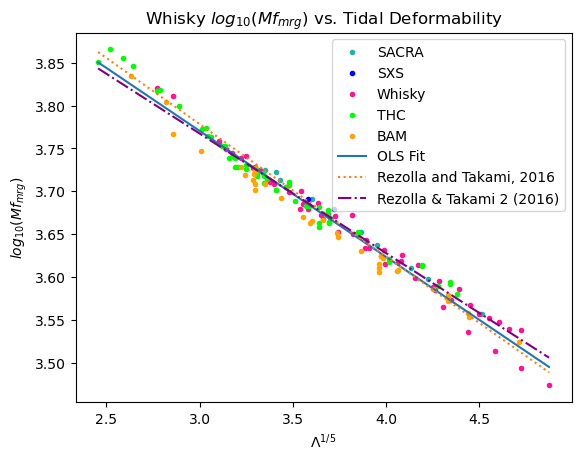

In [18]:
#Code_List = ['SACRA', 'SXS', 'Whisky', 'THC', 'BAM'] 
Code_List = ['SACRA', 'SXS', 'Whisky', 'THC', 'BAM']
#Outliers = [155,169,174,250]
Outliers = [169,174]

print('Outliers:')
for ind in Outliers:
    print(df['Run Name'][ind], 'or', df['Identifier'][ind], parameters[1][ind], parameters[2][ind])
    
print()
print('Codes:')

#Define color dictionary
color_dict = {
    'SACRA': 'lightseagreen',
    'SXS': 'b',
    'Whisky': 'deeppink',
    'THC': 'lime',
    'BAM': 'orange',
}

fig, ax = plt.subplots()

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            plt.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], marker='.', label=df['Code'][i-1])
            print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q1][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            if 1 - parameters[1][i] <= 0.01: #0.01 seems to include only q=1
                if i not in Outliers: #THis is to test fit with the outliers removed
                    #print(parameters[1][i])

                    Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q1][i])))
                    Mf_List_Lambs.append(df['Λ'][i]**(1/5))

            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
plt.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], marker='.', label=df['Code'][name_ind])

print(len(Mf_List)) #Probably not needed as it is given in the summary
        
###-----------------------------------------------Fit------------------------------------------------------------------###

params_df = pd.DataFrame({
    'Lambda 0.2': np.array(Mf_List_Lambs)
})

params = params_df[['Lambda 0.2']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#plot our fit
test_lamb = np.linspace(min(Mf_List_Lambs),max(Mf_List_Lambs), 100)
val_fit = coefs[0] + coefs[1] * test_lamb
plt.plot(test_lamb, val_fit, label='OLS Fit')

#plot reference
val_test = 4.242 - 0.154544 * test_lamb
plt.plot(test_lamb, val_test, linestyle='dotted', label='Rezolla and Takami, 2016')

#2nd reference plot
val_test = 4.186 - 0.139519485 * test_lamb
plt.plot(test_lamb, val_test, color='purple', linestyle='dashdot', label='Rezolla & Takami 2 (2016)')

#plt.plot([3,3], [3.75,4], linestyle='dashed') #Highlight outlier



###-----------------------------------------Plot Labels--------------------------------------------###
plt.ylabel('$log_{10}(Mf_{mrg})$')
plt.xlabel('$\Lambda^{1/5}$')
plt.title('Whisky $log_{10}(Mf_{mrg})$ vs. Tidal Deformability')
plt.legend()
plt.show()

        

## Paper Plots

SACRA
SXS
Whisky
THC
BAM
158
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     2629.
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           1.52e-99
Time:                        09:15:27   Log-Likelihood:                 408.81
No. Observations:                 158   AIC:                            -813.6
Df Residuals:                     156   BIC:                            -807.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1937  

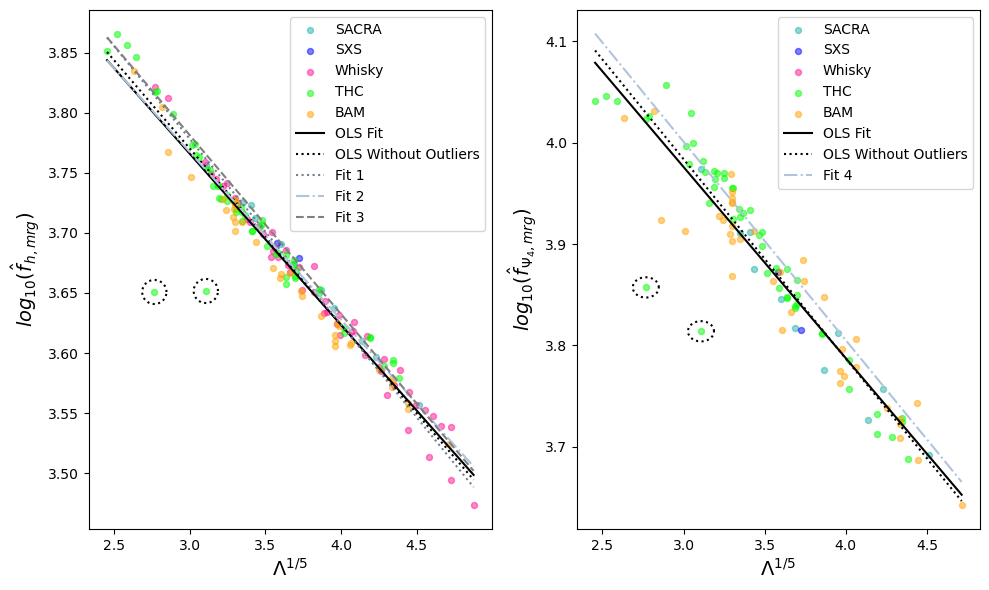

In [16]:
#Make sure to run the the code a couple cells above that finds the ones that need rescaled (defined rescale_runs list) 

#fig,ax = plt.subplot(2,1,figsize=(10,5))
Code_List = ['SACRA', 'SXS', 'Whisky', 'THC', 'BAM'] 
#Code_List = ['THC']
#Code_List = ['SACRA', 'Whisky', 'THC', 'BAM'] 
#Code_List = ['SACRA', 'SXS', 'Whisky','BAM']
#EOS_List = ['ALF2', 'APR4', 'GNH3', 'H4', 'SLy'] #Without GAM2 for comparison to paper

#Define color dictionary
color_dict = {
    'SACRA': 'lightseagreen',
    'SXS': 'b',
    'Whisky': 'deeppink',
    'THC': 'lime',
    'BAM': 'orange',
}

#color_dict = {
#    'SACRA': 'teal',
#    'SXS': 'darkblue',
#    'Whisky': 'red',
#    'THC': 'purple',
#    'BAM': 'gold',
#}

fig = plt.figure(figsize=(10, 6))
###---------------------------------------------Strain-------------------------------------------------###
Outliers = [169,174] #Strain Outliers
#Create Subplot
ax1 = fig.add_subplot(1,2,1)

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            plt.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], alpha=0.5, s=75, marker='.', label=df['Code'][i-1])
            print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q1][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            if 1 - parameters[1][i] <= 0.01: #0.01 seems to include only q=1
                #print(parameters[1][i])
            
                #This was to check the types to ensure we could multiply
                #print(type((parameters[2][i])), type(df['f2,h [R01]'][i]), type(df['Λ'][i]))

                Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q1][i])))
                Mf_List_Lambs.append(df['Λ'][i]**(1/5))
            
            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
ax1.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], alpha=0.5, s=75, marker='.', label=df['Code'][name_ind])

print(len(Mf_List)) #Probably not needed as it is given in the summary
        
###-----------------------------------------------Fit------------------------------------------------------------------###

params_df = pd.DataFrame({
    'Lambda 0.2': np.array(Mf_List_Lambs)
})

params = params_df[['Lambda 0.2']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#plot our fit
test_lamb = np.linspace(min(Mf_List_Lambs),max(Mf_List_Lambs), 100)
val_fit = coefs[0] + coefs[1] * test_lamb
plt.plot(test_lamb, val_fit, color='k', label='OLS Fit')

#With outliers removed
val_test = 4.2114 - 0.1470 * test_lamb
plt.plot(test_lamb, val_test, color='k', linestyle='dotted', label='OLS Without Outliers')

#plot reference
val_test = 4.242 - 0.154544 * test_lamb
plt.plot(test_lamb, val_test, color='slategrey', linestyle='dotted', label='Fit 1')

#2nd reference plot
val_test = 4.186 - 0.139519485 * test_lamb
plt.plot(test_lamb, val_test, color='lightsteelblue', linestyle='dashdot', label='Fit 2')

#3rd reference plot
val_test = 4.2285 - 0.149 * test_lamb
plt.plot(test_lamb, val_test, color='grey', linestyle='dashed', label='Fit 3')

#plt.plot([3,3], [3.75,4], linestyle='dashed') #Highlight outlier

###------------------------------------------Circle Outliers------------------------------------------------###
for ind in Outliers:
    theta = np.linspace(0,2*np.pi,100)
    x1 = 8*(0.01)*np.cos(theta)
    y1 = 0.01*np.sin(theta)
    ax1.plot(x1+df['Λ'][ind]**(1/5),y1+np.log10(1000*(parameters[2][ind])*float(df[fit_q1][ind])), color='k', linestyle='dotted')
    #ax1.Circle((df['Λ'][ind]**(1/5), np.log10(1000*(parameters[2][ind])*float(df['fmrg,h'][ind]))), 2, fill=False)

###---------------------------------------Plot Labels-------------------------------------------------------###
#ax1.set_ylabel('$log_{10}(Mf_{mrg})$')
#ax1.set_ylabel(r'$\log_{10}(\frac{M}{M_{\odot}} \frac{f_{mrg}}{Hz})$')
#ax1.set_xlabel('$\Lambda^{1/5}$')
ax1.set_ylabel(r'$log_{10}({\hat f_{h,mrg}})$',fontsize=14)
ax1.set_xlabel('$\Lambda^{1/5}$',fontsize=14)
#plt.title('Whisky $log_{10}(Mf_{mrg})$ vs. Tidal Deformability')
ax1.legend(prop={'size':10})
#plt.show()
#ax1.tick_params(axis='both', labelsize=2)
#ax1.xticks(fontsize=20)

        

###----------------------------------------------Psi4--------------------------------------------------###
Outliers = [169,174]
#Create Subplot
ax1 = fig.add_subplot(1,2,2)

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            plt.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], alpha=0.5, s=75, marker='.', label=df['Code'][i-1])
            print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            if 1 - parameters[1][i] <= 0.01: #0.01 seems to include only q=1
                #print(parameters[1][i])
            
                #This was to check the types to ensure we could multiply
                #print(type((parameters[2][i])), type(df['f2,h [R01]'][i]), type(df['Λ'][i]))
                
                if i in rescale_runs:
                    
                    Mf_List.append(np.log10(1000*float(df[fit_q][i]))) #Removed multiplication by M as it is already.
                    Mf_List_Lambs.append(df['Λ'][i]**(1/5))
                    
                    
                else:

                    Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q][i])))
                    Mf_List_Lambs.append(df['Λ'][i]**(1/5))
            
            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
ax1.scatter(Mf_List_Lambs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], alpha=0.5, s=75, marker='.', label=df['Code'][name_ind])

print(len(Mf_List)) #Probably not needed as it is given in the summary
        
###-----------------------------------------------Fit------------------------------------------------------------------###

params_df = pd.DataFrame({
    'Lambda 0.2': np.array(Mf_List_Lambs)
})

params = params_df[['Lambda 0.2']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#plot our fit
test_lamb = np.linspace(min(Mf_List_Lambs),max(Mf_List_Lambs), 100)
val_fit = coefs[0] + coefs[1] * test_lamb
plt.plot(test_lamb, val_fit, color='k', label='OLS Fit')

#With outliers removed
val_test = 4.5748 - 0.1970 * test_lamb
plt.plot(test_lamb, val_test, color='k', linestyle='dotted', label='OLS Without Outliers')

#plot reference
#val_test = 4.242 - 0.154544 * test_lamb
#plt.plot(test_lamb, val_test, color='slategrey', linestyle='dotted', label='Rezolla & Takami (2016)')

#2nd reference plot
val_test = 4.589 - 0.196 * test_lamb
plt.plot(test_lamb, val_test, color='lightsteelblue', linestyle='dashdot', label='Fit 4')

#3rd reference plot
#val_test = 4.2285 - 0.149 * test_lamb
#plt.plot(test_lamb, val_test, color='grey', linestyle='dashed', label='SACRA-MPI')

#plt.plot([3,3], [3.75,4], linestyle='dashed') #Highlight outlier

###------------------------------------------Circle Outliers------------------------------------------------###
for ind in Outliers:
    theta = np.linspace(0,2*np.pi,100)
    x1 = 8*(0.01)*np.cos(theta)
    y1 = 0.01*np.sin(theta)
    ax1.plot(x1+df['Λ'][ind]**(1/5),y1+np.log10(1000*(parameters[2][ind])*float(df[fit_q][ind])), color='k', linestyle='dotted')
    #ax1.Circle((df['Λ'][ind]**(1/5), np.log10(1000*(parameters[2][ind])*float(df['fmrg,h'][ind]))), 2, fill=False)

###---------------------------------------Plot Labels-------------------------------------------------------###
#ax1.set_ylabel('$log_{10}(Mf_{mrg})$')
#ax1.set_ylabel(r'$\log_{10}(\frac{M}{M_{\odot}} \frac{f_{mrg}}{Hz})$',fontsize=14)
ax1.set_ylabel(r'$log_{10}({\hat f_{\Psi_4,mrg}})$',fontsize=14)
ax1.set_xlabel('$\Lambda^{1/5}$',fontsize=14)
#plt.title('Whisky $log_{10}(Mf_{mrg})$ vs. Tidal Deformability')
ax1.legend(prop={'size':10})
#plt.show()
#ax1.tick_params(axis='both', labelsize=2)
#ax1.xticks(fontsize=20)
plt.tight_layout()
#plt.savefig('Pictures/Paper_Plots2/Merger_Equal_Mass_Fits.pdf', dpi=300, format='pdf')  # Save as PDF
        




SACRA
SXS
Whisky
THC
BAM
271
271
271
271
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     271.3
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           9.68e-81
Time:                        09:16:29   Log-Likelihood:                 483.37
No. Observations:                 271   AIC:                            -958.7
Df Residuals:                     267   BIC:                            -944.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

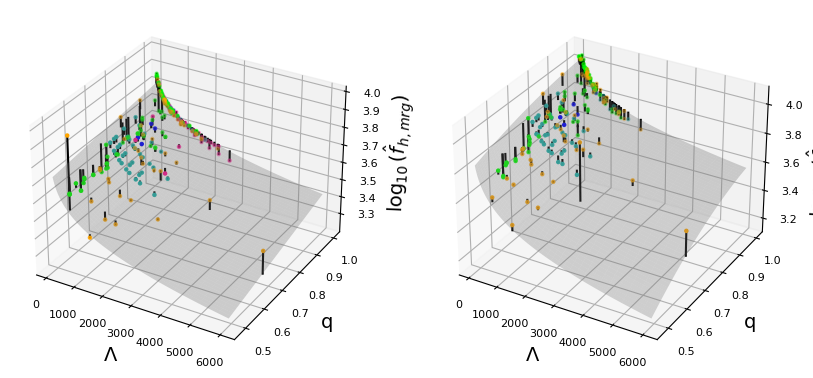

In [17]:
#Make sure to run the the code a couple cells above that finds the ones that need rescaled (defined rescale_runs list) 

#fig,ax = plt.subplot(2,1,figsize=(10,5))
Code_List = ['SACRA', 'SXS', 'Whisky', 'THC', 'BAM'] 
#Code_List = ['THC']
#Code_List = ['SACRA', 'Whisky', 'THC', 'BAM'] 
#Code_List = ['SACRA', 'SXS', 'Whisky','BAM']
#EOS_List = ['ALF2', 'APR4', 'GNH3', 'H4', 'SLy'] #Without GAM2 for comparison to paper

#Define color dictionary
color_dict = {
    'SACRA': 'lightseagreen',
    'SXS': 'b',
    'Whisky': 'deeppink',
    'THC': 'lime',
    'BAM': 'orange',
}

#color_dict = {
#    'SACRA': 'teal',
#    'SXS': 'darkblue',
#    'Whisky': 'red',
#    'THC': 'purple',
#    'BAM': 'gold',
#}

fig = plt.figure(figsize=(10, 6))
###----------------------------------------------Strain------------------------------------------------###
ax = fig.add_subplot(1,2,1,projection = '3d')

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []
Mf_List_qs = []
Mf_List_qLambs = []
Mf_List_q2Lambs = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            if df['Code'][i-1] in Code_List:
                ax.scatter(np.array(Mf_List_Lambs[start_ind:])**5, Mf_List_qs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], marker='.', label=df['Code'][i-1])
                print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q1][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            #This was to check the types to ensure we could multiply
            #print(type((parameters[2][i])), type(df['f2,h [R01]'][i]), type(df['Λ'][i]))
            
            Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q1][i])))
            Mf_List_Lambs.append(df['Λ'][i]**(1/5))
            Mf_List_qs.append(parameters[1][i])
            Mf_List_qLambs.append(parameters[1][i]*(df['Λ'][i]**(1/5)))
            Mf_List_q2Lambs.append((parameters[1][i]**2)*(df['Λ'][i]**(1/5)))
            
            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
ax.scatter(np.array(Mf_List_Lambs[start_ind:])**5, Mf_List_qs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], marker='.', label=df['Code'][name_ind])
        
###-----------------------------------------------Fit------------------------------------------------------------------###

print(len(Mf_List_Lambs))
print(len(Mf_List_qs))
print(len(Mf_List_qLambs))
print(len(Mf_List_q2Lambs))
params_df = pd.DataFrame({
    'Lambda 0.2 (Lamb)': Mf_List_Lambs,
    'q Lamb': Mf_List_qLambs,
    'q2 Lamb': Mf_List_q2Lambs,
    'q': Mf_List_qs
})

params = params_df[['Lambda 0.2 (Lamb)', 'q Lamb', 'q2 Lamb']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#Now we want to plot the fit

#Start by making a 2D grid (meshgrid) for lambda^1/5 and q (mass ratio)
lambs_grid, qs_grid = np.meshgrid(
    np.linspace(params['Lambda 0.2 (Lamb)'].min(), params['Lambda 0.2 (Lamb)'].max(), 50),
    np.linspace(params_df['q'].min(), params_df['q'].max(), 50)
)
#print(lambs_grid)

#Prediction
mrg_freq_predict = np.array([[coefs['const']+(coefs['Lambda 0.2 (Lamb)']+coefs['q Lamb']*qs_grid[i][j]+coefs['q2 Lamb']*(qs_grid[i][j]**2))*lambs_grid[i][j] for j in range(50)] for i in range(50)])
print(mrg_freq_predict)
#mrg_freq_paper = np.array([[4.201+(-0.330+0.198*qs_grid[i][j]-0.067*(qs_grid[i][j]**2))*((3/16)**(1/5))*lambs_grid[i][j] for j in range(50)] for i in range(50)])

#for i in range
print()

#Plot Prediction
ax.plot_surface(lambs_grid**5, qs_grid, mrg_freq_predict, color='grey', alpha=0.3, label='Predicted Surface') #Color options: red,grey
#ax.plot_surface(lambs_grid, qs_grid, mrg_freq_paper, color='blue', alpha=0.3, label='Paper Predicted Surface')


###------------------------------------Adding visuals for error---------------------------------------###
#print('list coeffs')
for k in range(len(Mf_List)):
    #print(coefs[0], coefs[1], coefs[2], coefs[3])
    prediction = coefs[0] + coefs[1]*Mf_List_Lambs[k] + coefs[2]*Mf_List_qLambs[k]+ coefs[3]*Mf_List_q2Lambs[k]
    ax.plot([Mf_List_Lambs[k]**5, Mf_List_Lambs[k]**5], [Mf_List_qs[k], Mf_List_qs[k]], [prediction, Mf_List[k]], color='k')
    


###------------------------------------Plot Set-up and Labels------------------------------------------###
# Configure the plot
ax.set_xlabel('$Λ$',fontsize=14)
ax.set_ylabel('q', fontsize=14)
#ax.set_zlabel('$log_{10}(Mf_{mrg})$')
#ax.set_zlabel(r'$\log_{10}(\frac{M}{M_{\odot}} \frac{f_{mrg}}{Hz})$')
ax.set_zlabel(r'$\log_{10}(\hat f_{h,mrg})$', fontsize=14)

#plt.title('$f_{mrg}$ vs. Tidal Deformability and Mass Ratio')
#ax.legend(loc='upper left', bbox_to_anchor=(1,1)) # Adjust legend location as needed
#ax.legend()
ax.grid(True)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=8)
elev = -25.0 # -30.0  #About q axis
azim = 0.0 #about frequency axis (Check (0,90,0), (0,0,0), (0,45,0), (-15,0,0) with all True) (-30,0,0) without SXS
roll = 0.0 #About lambda axis
#ax.view_init(elev, azim, roll)

#plt.show()
#fig.savefig('./Pictures/Paper_Plots/Merger_Freq_QU_Strain.png')

###-------------------------------------------------Psi4-----------------------------------------------###

ax = fig.add_subplot(1,2,2,projection = '3d')

start_ind = 0  #starting index of current code to plot

Mf_List = []
Mf_List_Lambs = []
Mf_List_qs = []
Mf_List_qLambs = []
Mf_List_q2Lambs = []
ID_names = []

for i in range(len(df['Run Name'])):
    
    #Check if the next data set has been reached and plot
    if i >= 1:   #Exclude the first to prevent error
        if df['Code'][i] != df['Code'][i-1]: #Note that this currently will not print the BAM scatterplot
            if df['Code'][i-1] in Code_List:
                ax.scatter(np.array(Mf_List_Lambs[start_ind:])**5, Mf_List_qs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][i-1]], marker='.', label=df['Code'][i-1])
                print(df['Code'][i-1])
            start_ind = len(Mf_List) #This is because we need the index after current last one
    
    #Check to make sure there is a valid entry (not -)
    if df[fit_q][i] != '-':
        
        if df['Code'][i] in Code_List:
            
            #This was to check the types to ensure we could multiply
            #print(type((parameters[2][i])), type(df['f2,h [R01]'][i]), type(df['Λ'][i]))
            
            if i in rescale_runs:
                if float(df[fit_q][i])/(parameters[2][i]) > 1:
                    Mf_List.append(np.log10(1000*float(df[fit_q][i]))) #Remove mult. by M as it already is
                    Mf_List_Lambs.append(df['Λ'][i]**(1/5))
                    Mf_List_qs.append(parameters[1][i])
                    Mf_List_qLambs.append(parameters[1][i]*(df['Λ'][i]**(1/5)))
                    Mf_List_q2Lambs.append((parameters[1][i]**2)*(df['Λ'][i]**(1/5)))
                    ID_names.append(df['Identifier'][i])
                    
                else:
                    print('Skipped',df['Identifier'][i])
            
            else:
                if float(df[fit_q][i]) > 1:
                    Mf_List.append(np.log10(1000*(parameters[2][i])*float(df[fit_q][i])))
                    Mf_List_Lambs.append(df['Λ'][i]**(1/5))
                    Mf_List_qs.append(parameters[1][i])
                    Mf_List_qLambs.append(parameters[1][i]*(df['Λ'][i]**(1/5)))
                    Mf_List_q2Lambs.append((parameters[1][i]**2)*(df['Λ'][i]**(1/5)))
                    ID_names.append(df['Identifier'][i])
                    
                else:
                    print('Skipped',df['Identifier'][i])
            
    

#Now we need to do the scatterplot of the last code (In this case BAM)
name_ind = len(df['Code'])-1
print(df['Code'][name_ind])
ax.scatter(np.array(Mf_List_Lambs[start_ind:])**5, Mf_List_qs[start_ind:], Mf_List[start_ind:], color=color_dict[df['Code'][name_ind]], marker='.', label=df['Code'][name_ind])
        
###-----------------------------------------------Fit------------------------------------------------------------------###

print(len(Mf_List_Lambs))
print(len(Mf_List_qs))
print(len(Mf_List_qLambs))
print(len(Mf_List_q2Lambs))
params_df = pd.DataFrame({
    'Lambda 0.2 (Lamb)': Mf_List_Lambs,
    'q Lamb': Mf_List_qLambs,
    'q2 Lamb': Mf_List_q2Lambs,
    'q': Mf_List_qs
})

params = params_df[['Lambda 0.2 (Lamb)', 'q Lamb', 'q2 Lamb']]
params = sm.add_constant(params)
#print(params)

model = sm.OLS(Mf_List, params).fit()

print(model.summary())
coefs = model.params
print(coefs)

#Now we want to plot the fit

#Start by making a 2D grid (meshgrid) for lambda^1/5 and q (mass ratio)
lambs_grid, qs_grid = np.meshgrid(
    np.linspace(params['Lambda 0.2 (Lamb)'].min(), params['Lambda 0.2 (Lamb)'].max(), 50),
    np.linspace(params_df['q'].min(), params_df['q'].max(), 50)
)
#print(lambs_grid)

#Prediction
mrg_freq_predict = np.array([[coefs['const']+(coefs['Lambda 0.2 (Lamb)']+coefs['q Lamb']*qs_grid[i][j]+coefs['q2 Lamb']*(qs_grid[i][j]**2))*lambs_grid[i][j] for j in range(50)] for i in range(50)])
print(mrg_freq_predict)
#mrg_freq_paper = np.array([[4.201+(-0.330+0.198*qs_grid[i][j]-0.067*(qs_grid[i][j]**2))*((3/16)**(1/5))*lambs_grid[i][j] for j in range(50)] for i in range(50)])

#for i in range
print()

#Plot Prediction
ax.plot_surface(lambs_grid**5, qs_grid, mrg_freq_predict, color='grey', alpha=0.3, label='Predicted Surface') #Color options: red,grey
#ax.plot_surface(lambs_grid, qs_grid, mrg_freq_paper, color='blue', alpha=0.3, label='Paper Predicted Surface')


###------------------------------------Adding visuals for error---------------------------------------###
#print('list coeffs')
for k in range(len(Mf_List)):
    #print(coefs[0], coefs[1], coefs[2], coefs[3])
    prediction = coefs[0] + coefs[1]*Mf_List_Lambs[k] + coefs[2]*Mf_List_qLambs[k]+ coefs[3]*Mf_List_q2Lambs[k]
    ax.plot([Mf_List_Lambs[k]**5, Mf_List_Lambs[k]**5], [Mf_List_qs[k], Mf_List_qs[k]], [prediction, Mf_List[k]], color='k')
    


###------------------------------------Plot Set-up and Labels------------------------------------------###
# Configure the plot
ax.set_xlabel('$Λ$',fontsize=14)
ax.set_ylabel('q', fontsize=14)
#ax.set_zlabel('$log_{10}(Mf_{mrg})$')
#ax.set_zlabel(r'$\log_{10}(\frac{M}{M_{\odot}} \frac{f_{mrg}}{Hz})$')
ax.set_zlabel(r'$\log_{10}(\hat f_{\Psi_4,mrg})$', fontsize=14)

#plt.title('$f_{mrg}$ vs. Tidal Deformability and Mass Ratio')
#ax.legend(loc='upper left', bbox_to_anchor=(1,1)) # Adjust legend location as needed
#ax.legend()
ax.grid(True)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.tick_params(axis='z', labelsize=8)
elev = -25.0 # -30.0  #About q axis
azim = 0.0 #about frequency axis (Check (0,90,0), (0,0,0), (0,45,0), (-15,0,0) with all True) (-30,0,0) without SXS
roll = 0.0 #About lambda axis
#ax.view_init(elev, azim, roll)
#plt.tight_layout() #using tight_layout gets tid of the z-axis labels
#plt.show()
#fig.savefig('./Pictures/Paper_Plots/Merger_Freq_QU_Psi4.png')
#plt.savefig('Pictures/Paper_Plots2/Merger_3D.pdf', dpi=300, format='pdf')  # Save as PDF